In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import tensorflow as tf
import warnings
from tensorflow.keras.callbacks import TensorBoard

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('Shanghai license plate price.csv')
data

,Date,Total number of license issued,lowest price,avg price,Total number of applicants
0,Jan-02,1400,13600,14735,3718
1,Feb-02,1800,13100,14057,4590
2,Mar-02,2000,14300,14662,5190
3,Apr-02,2300,16000,16334,4806
4,May-02,2350,17800,18357,4665
...,...,...,...,...,...
199,Sep-18,12712,87300,87410,189142
200,Oct-18,10728,88000,88070,181861
201,Nov-18,11766,87300,87374,177355
202,Dec-18,12850,87400,87508,165442


In [3]:
data = data.rename(columns={'Total number of license issued': 'License issued', 'avg price': 'Avg', 
                            'Total number of applicants': 'Total applicants'})
data.columns.values[2] = "Lowest"

In [4]:
features = ['License issued', 'Lowest', 'Avg', 'Total applicants']

In [5]:
data

,Date,License issued,Lowest,Avg,Total applicants
0,Jan-02,1400,13600,14735,3718
1,Feb-02,1800,13100,14057,4590
2,Mar-02,2000,14300,14662,5190
3,Apr-02,2300,16000,16334,4806
4,May-02,2350,17800,18357,4665
...,...,...,...,...,...
199,Sep-18,12712,87300,87410,189142
200,Oct-18,10728,88000,88070,181861
201,Nov-18,11766,87300,87374,177355
202,Dec-18,12850,87400,87508,165442


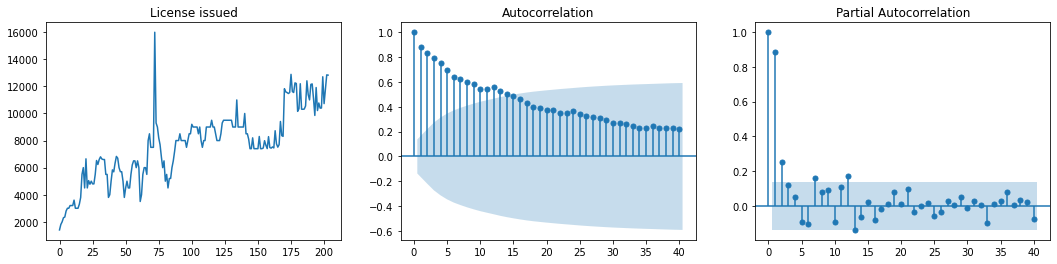

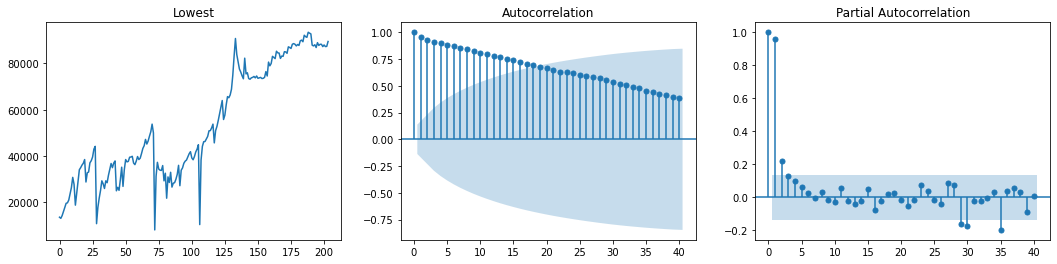

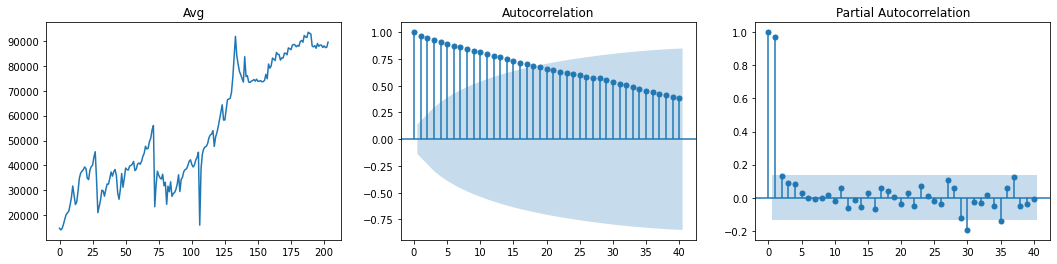

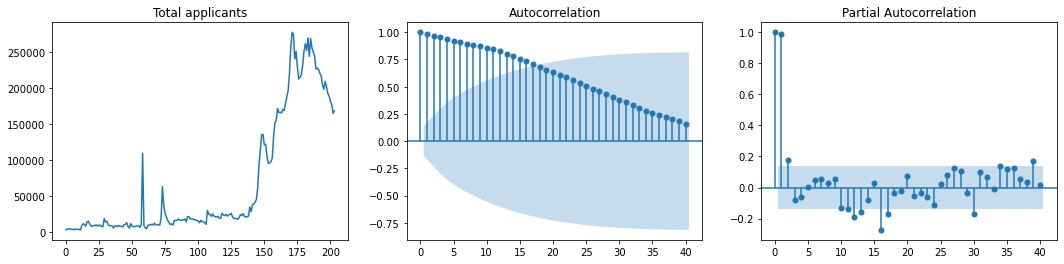

In [6]:
for feat in ['License issued', 'Lowest', 'Avg', 'Total applicants']:
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    axes[0].plot(data[feat])
    axes[0].set_title(feat)
    plot_acf(data[feat], lags=40, ax=axes[1])
    plot_pacf(data[feat], lags=40, ax=axes[2])
    plt.show()

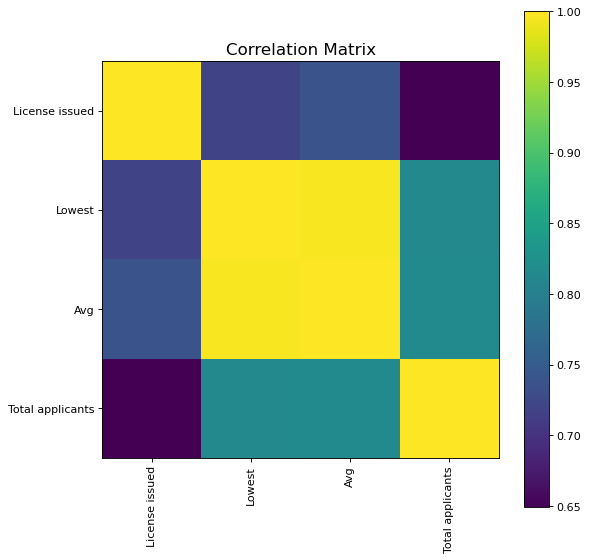

In [7]:
corr = data.corr()
plt.figure(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
corr_mat = plt.matshow(corr, fignum = 1)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.gca().xaxis.tick_bottom()
plt.colorbar(corr_mat)
plt.title(f'Correlation Matrix', fontsize=15)
plt.show()

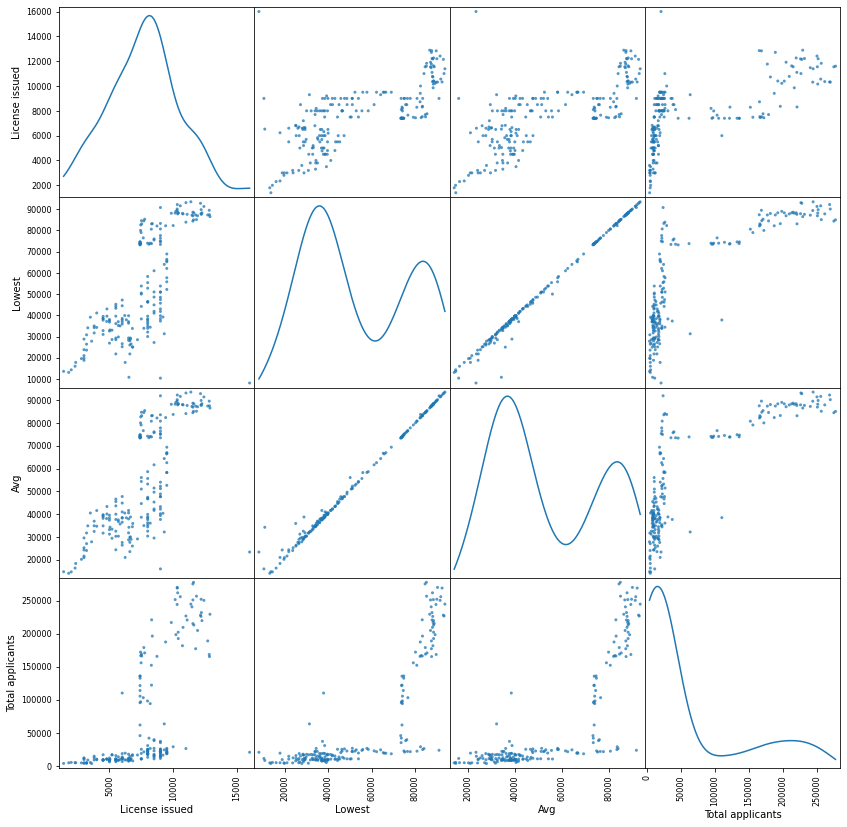

In [8]:
df = data[features]
ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[14, 14], diagonal='kde')
corrs = df.corr().values
plt.show()

# Разбиваю выборку. 10% тест, 20% валидация, 70% тренировочная

In [9]:
n = len(data)
training = data[0: int(n * 0.7)][features]
validation = data[int(n * 0.7): int(n * 0.9)][features]
test = data[int(n * 0.9):][features]

In [10]:
print(training.shape)
print(validation.shape)
print(test.shape)

(142, 4)
(41, 4)
(21, 4)


# Стандартизирую

In [11]:
training_mean = training.mean()
training_std = training.std()

In [12]:
training_scaled = (training - training_mean) / training_std
validation_scaled = (validation - training_mean) / training_std
test_scaled = (test - training_mean) / training_std

In [13]:
training_scaled.shape

(142, 4)

# Тренируюсь на 5-ти последних днях, предсказываю следующий

In [14]:
trained_days = 5
predict_days = 1

# Разметка выборки. Скользящим окном создаю объекты для обучения, валидации и теста

In [15]:
def get_windows(arr, size=trained_days + predict_days):
    shape = arr.shape[:-1] + (arr.shape[-1] - size + 1, size)
    strides = arr.strides + (arr.strides[-1],)
    return np.lib.stride_tricks.as_strided(arr, shape=shape, strides=strides)

training_windows = np.stack([get_windows(training_scaled[feat].values) for feat in features], axis=2)
x_train = training_windows[:, :5, :]
y_train = training_windows[:, 5:, 1]

validation_windows = np.stack([get_windows(validation_scaled[feat].values) for feat in features], axis=2)
x_val = validation_windows[:, :5, :]
y_val = validation_windows[:, 5:, 1]

test_windows = np.stack([get_windows(test_scaled[feat].values) for feat in features], axis=2)
x_test = test_windows[:, :5, :]
y_test = test_windows[:, 5:, 1]

In [16]:
x_train.shape

(137, 5, 4)

In [17]:
history = {}

In [18]:
x_train.shape, y_train.shape

((137, 5, 4), (137, 1))

In [19]:
def get_board_callback(name):
    log_dir = "logs/fit/"
    return TensorBoard(log_dir=log_dir + name, histogram_freq=1)

# Model 1. SimpleRNN

In [20]:
inp = tf.keras.layers.Input((trained_days, 4))
rnn = tf.keras.layers.SimpleRNN(128)(inp)
out = tf.keras.layers.Dense(predict_days, activation='linear')(rnn)

model1 = tf.keras.Model(inp, out)
model1.compile(loss='mse', optimizer='adam', metrics=('mse', 'mae', 'mape'))
model1.summary()

history['1 layer SimpleRNN'] = model1.fit(x_train, y_train, validation_data=(x_val, y_val), 
                               callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40),
                                          get_board_callback("Model1")], epochs=300)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 4)]            0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               17024     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 17,153
Trainable params: 17,153
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
5/5 [==============================] - 1s 70ms/step - loss: 0.5397 - mse: 0.5397 - mae: 0.5790 - mape: 259.5700 - val_loss: 4.1441 - val_mse: 4.1441 - val_mae: 1.9405 - val_mape: 75.1062
Epoch 2/300
5/5 [==============================] - 0s 9ms/step - loss: 0.3142 - mse: 0.3142 - mae: 0.4150 - mape: 172.7551 - val_loss: 3.4814 - val_mse: 3.4814 - val_mae: 1.7500 - val_mape

5/5 [==============================] - 0s 10ms/step - loss: 0.1363 - mse: 0.1363 - mae: 0.2673 - mape: 132.2702 - val_loss: 3.6997 - val_mse: 3.6997 - val_mae: 1.7975 - val_mape: 68.9522
Epoch 39/300
5/5 [==============================] - 0s 9ms/step - loss: 0.1145 - mse: 0.1145 - mae: 0.2270 - mape: 104.5485 - val_loss: 3.9147 - val_mse: 3.9147 - val_mae: 1.8674 - val_mape: 71.9386
Epoch 40/300
5/5 [==============================] - 0s 9ms/step - loss: 0.1219 - mse: 0.1219 - mae: 0.2179 - mape: 80.7646 - val_loss: 3.8272 - val_mse: 3.8272 - val_mae: 1.8382 - val_mape: 70.6809
Epoch 41/300
5/5 [==============================] - 0s 9ms/step - loss: 0.1124 - mse: 0.1124 - mae: 0.2285 - mape: 96.5432 - val_loss: 3.6487 - val_mse: 3.6487 - val_mae: 1.7780 - val_mape: 68.0998
Epoch 42/300
5/5 [==============================] - 0s 9ms/step - loss: 0.1218 - mse: 0.1218 - mae: 0.2450 - mape: 108.5554 - val_loss: 3.4974 - val_mse: 3.4974 - val_mae: 1.7321 - val_mape: 66.2088
Epoch 43/300
5/5 [=

# Model 2. Однослойный LSTM

In [21]:
inp = tf.keras.layers.Input((trained_days, 4))
lstm = tf.keras.layers.LSTM(128)(inp)
out = tf.keras.layers.Dense(predict_days, activation='linear')(lstm)

model2 = tf.keras.Model(inp, out)
model2.compile(loss='mse', optimizer='adam',
                metrics=('mse', 'mae', 'mape'))
model2.summary()

history['1 layer LSTM'] = model2.fit(x_train, y_train, validation_data=(x_val, y_val), 
                               callbacks=(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40),
                                          get_board_callback("Model1")), epochs=300)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5, 4)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               68096     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 68,225
Trainable params: 68,225
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
5/5 [==============================] - 2s 158ms/step - loss: 0.6549 - mse: 0.6549 - mae: 0.5853 - mape: 102.4964 - val_loss: 1.2657 - val_mse: 1.2657 - val_mae: 1.0482 - val_mape: 40.1066
Epoch 2/300
5/5 [==============================] - 0s 14ms/step - loss: 0.3015 - mse: 0.3015 - mae: 0.3918 - mape: 130.9667 - val_loss: 0.4539 - val_mse: 0.4539 - val_mae: 0.5814 - val_

5/5 [==============================] - 0s 14ms/step - loss: 0.1665 - mse: 0.1665 - mae: 0.2638 - mape: 94.7714 - val_loss: 2.2417 - val_mse: 2.2417 - val_mae: 1.2130 - val_mape: 44.4735
Epoch 39/300
5/5 [==============================] - 0s 13ms/step - loss: 0.1659 - mse: 0.1659 - mae: 0.2634 - mape: 95.3755 - val_loss: 2.1661 - val_mse: 2.1661 - val_mae: 1.1864 - val_mape: 43.4718
Epoch 40/300
5/5 [==============================] - 0s 14ms/step - loss: 0.1654 - mse: 0.1654 - mae: 0.2615 - mape: 93.9084 - val_loss: 2.1726 - val_mse: 2.1726 - val_mae: 1.1886 - val_mape: 43.5621
Epoch 41/300
5/5 [==============================] - 0s 16ms/step - loss: 0.1635 - mse: 0.1635 - mae: 0.2583 - mape: 92.5597 - val_loss: 2.2059 - val_mse: 2.2059 - val_mae: 1.2025 - val_mape: 44.0937
Epoch 42/300
5/5 [==============================] - 0s 14ms/step - loss: 0.1640 - mse: 0.1640 - mae: 0.2580 - mape: 92.5110 - val_loss: 2.2362 - val_mse: 2.2362 - val_mae: 1.2136 - val_mape: 44.5311
Epoch 43/300
5/5 [

# Model 3. Однослойный GRU

In [22]:
inp = tf.keras.layers.Input((trained_days, 4))
gru = tf.keras.layers.GRU(128)(inp)
out = tf.keras.layers.Dense(predict_days, activation='linear')(gru)

model3 = tf.keras.Model(inp, out)
model3.compile(loss='mse', optimizer='adam',
                metrics=('mse', 'mae', 'mape'))
model3.summary()

history['1 layer GRU'] = model3.fit(x_train, y_train, validation_data=(x_val, y_val), 
                               callbacks=(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40),
                                          get_board_callback("Model1")), epochs=400)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 5, 4)]            0         
_________________________________________________________________
gru (GRU)                    (None, 128)               51456     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 51,585
Trainable params: 51,585
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
5/5 [==============================] - 2s 116ms/step - loss: 1.1661 - mse: 1.1661 - mae: 0.7958 - mape: 136.9382 - val_loss: 8.2462 - val_mse: 8.2462 - val_mae: 2.7921 - val_mape: 109.2386
Epoch 2/400
5/5 [==============================] - 0s 9ms/step - loss: 0.4905 - mse: 0.4905 - mae: 0.5200 - mape: 130.1303 - val_loss: 4.6501 - val_mse: 4.6501 - val_mae: 2.0180 - val_

5/5 [==============================] - 0s 13ms/step - loss: 0.1618 - mse: 0.1618 - mae: 0.2365 - mape: 73.7214 - val_loss: 0.6467 - val_mse: 0.6467 - val_mae: 0.6725 - val_mape: 25.7261
Epoch 39/400
5/5 [==============================] - 0s 14ms/step - loss: 0.1607 - mse: 0.1607 - mae: 0.2343 - mape: 72.1406 - val_loss: 0.6698 - val_mse: 0.6698 - val_mae: 0.6776 - val_mape: 25.7385
Epoch 40/400
5/5 [==============================] - 0s 11ms/step - loss: 0.1591 - mse: 0.1591 - mae: 0.2358 - mape: 76.2601 - val_loss: 0.5985 - val_mse: 0.5985 - val_mae: 0.6578 - val_mape: 25.5924
Epoch 41/400
5/5 [==============================] - 0s 13ms/step - loss: 0.1608 - mse: 0.1608 - mae: 0.2388 - mape: 80.9158 - val_loss: 0.5696 - val_mse: 0.5696 - val_mae: 0.6444 - val_mape: 25.4421
Epoch 42/400
5/5 [==============================] - 0s 13ms/step - loss: 0.1582 - mse: 0.1582 - mae: 0.2357 - mape: 80.3525 - val_loss: 0.6313 - val_mse: 0.6313 - val_mae: 0.6708 - val_mape: 25.8749
Epoch 43/400
5/5 [

# Model 4. Однослойная сверточная сеть

In [23]:
inp = tf.keras.layers.Input((trained_days, 4))
conv = tf.keras.layers.Conv1D(128, 2)(inp)
flatten = tf.keras.layers.Flatten()(conv)
out = tf.keras.layers.Dense(predict_days, activation='linear')(flatten)

model4 = tf.keras.Model(inp, out)
model4.compile(loss='mse', optimizer='adam',
                metrics=('mse', 'mae', 'mape'))
model4.summary()

history['1 layer conv'] = model4.fit(x_train, y_train, validation_data=(x_val, y_val), 
                               callbacks=(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40),
                                          get_board_callback("Model4")), epochs=500)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 5, 4)]            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 4, 128)            1152      
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 1,665
Trainable params: 1,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
5/5 [==============================] - 1s 52ms/step - loss: 0.6313 - mse: 0.6313 - mae: 0.5735 - mape: 122.0265 - val_loss: 1.1338 - val_mse: 1.1338 - val_mae: 1.0185 - val_mape: 41.3533
Epoch 2/500
5/5 [==============================] - 0s 7m

Epoch 38/500
5/5 [==============================] - 0s 6ms/step - loss: 0.1695 - mse: 0.1695 - mae: 0.2372 - mape: 77.9163 - val_loss: 1.9395 - val_mse: 1.9395 - val_mae: 1.3066 - val_mape: 50.5177
Epoch 39/500
5/5 [==============================] - 0s 7ms/step - loss: 0.1669 - mse: 0.1669 - mae: 0.2281 - mape: 74.3837 - val_loss: 2.2263 - val_mse: 2.2263 - val_mae: 1.3928 - val_mape: 53.7363
Epoch 40/500
5/5 [==============================] - 0s 6ms/step - loss: 0.1663 - mse: 0.1663 - mae: 0.2260 - mape: 72.3556 - val_loss: 3.1226 - val_mse: 3.1226 - val_mae: 1.6550 - val_mape: 63.9087
Epoch 41/500
5/5 [==============================] - 0s 6ms/step - loss: 0.1652 - mse: 0.1652 - mae: 0.2299 - mape: 76.6996 - val_loss: 3.9731 - val_mse: 3.9731 - val_mae: 1.8706 - val_mape: 72.2749
Epoch 42/500
5/5 [==============================] - 0s 6ms/step - loss: 0.1677 - mse: 0.1677 - mae: 0.2396 - mape: 82.3110 - val_loss: 5.7631 - val_mse: 5.7631 - val_mae: 2.2473 - val_mape: 86.7313
Epoch 43/5

# Model 5. Deep SimpleRNN

In [24]:
inp = tf.keras.layers.Input((trained_days, 4))
rnn_1 = tf.keras.layers.SimpleRNN(512, return_sequences=True)(inp)
dropout = tf.keras.layers.Dropout(0.3)(rnn_1)
rnn_2 = tf.keras.layers.SimpleRNN(256, return_sequences=True)(dropout)
dropout = tf.keras.layers.Dropout(0.5)(rnn_2)
rnn_3 = tf.keras.layers.SimpleRNN(128)(dropout)
out = tf.keras.layers.Dense(predict_days, activation='linear')(rnn_3)

model5 = tf.keras.Model(inp, out)
model5.compile(loss='mse', optimizer='adam', metrics=('mse', 'mae', 'mape'))
model5.summary()

history['Deep SimpleRNN'] = model5.fit(x_train, y_train, validation_data=(x_val, y_val), 
                               callbacks=(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40),
                                          get_board_callback("Model5")), epochs=400)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 5, 4)]            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 5, 512)            264704    
_________________________________________________________________
dropout (Dropout)            (None, 5, 512)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 5, 256)            196864    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 256)            0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 128)               49280     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129 

Epoch 36/400
5/5 [==============================] - 0s 21ms/step - loss: 0.2476 - mse: 0.2476 - mae: 0.3925 - mape: 191.5174 - val_loss: 2.2256 - val_mse: 2.2256 - val_mae: 1.4497 - val_mape: 56.7531
Epoch 37/400
5/5 [==============================] - 0s 23ms/step - loss: 0.2399 - mse: 0.2399 - mae: 0.3606 - mape: 194.7614 - val_loss: 2.3372 - val_mse: 2.3372 - val_mae: 1.4933 - val_mape: 58.6212
Epoch 38/400
5/5 [==============================] - 0s 22ms/step - loss: 0.2176 - mse: 0.2176 - mae: 0.3716 - mape: 215.7328 - val_loss: 1.8948 - val_mse: 1.8948 - val_mae: 1.3318 - val_mape: 52.0388
Epoch 39/400
5/5 [==============================] - 0s 23ms/step - loss: 0.2460 - mse: 0.2460 - mae: 0.3708 - mape: 189.2718 - val_loss: 2.9504 - val_mse: 2.9504 - val_mae: 1.6871 - val_mape: 66.5099
Epoch 40/400
5/5 [==============================] - 0s 21ms/step - loss: 0.2169 - mse: 0.2169 - mae: 0.3877 - mape: 140.7178 - val_loss: 1.8196 - val_mse: 1.8196 - val_mae: 1.2975 - val_mape: 50.5793


# Model 6. Deep LSTM

In [25]:
inp = tf.keras.layers.Input((trained_days, 4))
lstm_1 = tf.keras.layers.LSTM(512, return_sequences=True)(inp)
dropout = tf.keras.layers.Dropout(0.2)(lstm_1)
lstm_2 = tf.keras.layers.LSTM(256, return_sequences=True)(dropout)
dropout = tf.keras.layers.Dropout(0.4)(lstm_2)
lstm_3 = tf.keras.layers.LSTM(128)(dropout)
out = tf.keras.layers.Dense(predict_days, activation='linear')(lstm_3)

model6 = tf.keras.Model(inp, out)
model6.compile(loss='mse', optimizer='adam',
                metrics=('mse', 'mae', 'mape'))
model6.summary()

history['Deep LSTM'] = model6.fit(x_train, y_train, validation_data=(x_val, y_val), 
                               callbacks=(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40),
                                          get_board_callback("Model6")), epochs=400)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 5, 4)]            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 512)            1058816   
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 512)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 256)            787456    
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 256)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129 

Epoch 36/400
5/5 [==============================] - 0s 42ms/step - loss: 0.1718 - mse: 0.1718 - mae: 0.2843 - mape: 106.0777 - val_loss: 5.1765 - val_mse: 5.1765 - val_mae: 1.9716 - val_mape: 73.9215
Epoch 37/400
5/5 [==============================] - 0s 46ms/step - loss: 0.1628 - mse: 0.1628 - mae: 0.2702 - mape: 93.9900 - val_loss: 5.8408 - val_mse: 5.8408 - val_mae: 2.1093 - val_mape: 79.2620
Epoch 38/400
5/5 [==============================] - 0s 46ms/step - loss: 0.1654 - mse: 0.1654 - mae: 0.2777 - mape: 106.0937 - val_loss: 7.7041 - val_mse: 7.7041 - val_mae: 2.5059 - val_mape: 95.2047
Epoch 39/400
5/5 [==============================] - 0s 48ms/step - loss: 0.1554 - mse: 0.1554 - mae: 0.2636 - mape: 100.4545 - val_loss: 8.7190 - val_mse: 8.7190 - val_mae: 2.7417 - val_mape: 105.1901
Epoch 40/400
5/5 [==============================] - 0s 47ms/step - loss: 0.1599 - mse: 0.1599 - mae: 0.2724 - mape: 99.8396 - val_loss: 6.2877 - val_mse: 6.2877 - val_mae: 2.2369 - val_mape: 84.6271
E

# Model 7. Deep GRU

In [26]:
inp = tf.keras.layers.Input((trained_days, 4))
gru_1 = tf.keras.layers.GRU(512, return_sequences=True)(inp)
dropout = tf.keras.layers.Dropout(0.2)(gru_1)
gru_2 = tf.keras.layers.GRU(256, return_sequences=True)(dropout)
dropout = tf.keras.layers.Dropout(0.2)(gru_2)
gru_3 = tf.keras.layers.GRU(128, return_sequences=True)(dropout)
dropout = tf.keras.layers.Dropout(0.6)(gru_3)
gru_4 = tf.keras.layers.GRU(64)(dropout)
out = tf.keras.layers.Dense(predict_days, activation='linear')(gru_4)

model7 = tf.keras.Model(inp, out)
model7.compile(loss='mse', optimizer='adam',
                metrics=('mse', 'mae', 'mape'))
model7.summary()

history['Deep GRU'] = model7.fit(x_train, y_train, validation_data=(x_val, y_val), 
                               callbacks=(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40),
                                          get_board_callback("Model7")), epochs=400)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 5, 4)]            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 5, 512)            795648    
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 512)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 5, 256)            591360    
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 256)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 5, 128)            148224    
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 128)            0   

5/5 [==============================] - 0s 41ms/step - loss: 0.1745 - mse: 0.1745 - mae: 0.2689 - mape: 106.3386 - val_loss: 0.2538 - val_mse: 0.2538 - val_mae: 0.4287 - val_mape: 15.9542
Epoch 35/400
5/5 [==============================] - 0s 41ms/step - loss: 0.1578 - mse: 0.1578 - mae: 0.2783 - mape: 138.2548 - val_loss: 0.1675 - val_mse: 0.1675 - val_mae: 0.3643 - val_mape: 14.0606
Epoch 36/400
5/5 [==============================] - 0s 41ms/step - loss: 0.1590 - mse: 0.1590 - mae: 0.2725 - mape: 107.7265 - val_loss: 0.2374 - val_mse: 0.2374 - val_mae: 0.4187 - val_mape: 15.6927
Epoch 37/400
5/5 [==============================] - 0s 41ms/step - loss: 0.1577 - mse: 0.1577 - mae: 0.2541 - mape: 98.5336 - val_loss: 0.3343 - val_mse: 0.3343 - val_mae: 0.4869 - val_mape: 18.0699
Epoch 38/400
5/5 [==============================] - 0s 42ms/step - loss: 0.1720 - mse: 0.1720 - mae: 0.2710 - mape: 115.6855 - val_loss: 1.0674 - val_mse: 1.0674 - val_mae: 0.9462 - val_mape: 36.0351
Epoch 39/400
5

# Model 8. Deep Conv

In [27]:
inp = tf.keras.layers.Input((trained_days, 4))
conv_1 = tf.keras.layers.Conv1D(64, 2, padding='same')(inp)
dropout = tf.keras.layers.Dropout(0.2)(conv_1)
conv_2 = tf.keras.layers.Conv1D(32, 2, padding='same')(dropout)
dropout = tf.keras.layers.Dropout(0.5)(conv_2)
flatten = tf.keras.layers.Flatten()(dropout)
out = tf.keras.layers.Dense(predict_days, activation='linear')(flatten)

model8 = tf.keras.Model(inp, out)
model8.compile(loss='mse', optimizer='adam', metrics=('mse', 'mae', 'mape'))
model8.summary()

history['Deep conv'] = model8.fit(x_train, y_train, validation_data=(x_val, y_val), 
                               callbacks=(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40),
                                          get_board_callback("Model8")), epochs=400)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 5, 4)]            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 64)             576       
_________________________________________________________________
dropout_7 (Dropout)          (None, 5, 64)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 32)             4128      
_________________________________________________________________
dropout_8 (Dropout)          (None, 5, 32)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 161 

Epoch 36/400
5/5 [==============================] - 0s 8ms/step - loss: 0.2466 - mse: 0.2466 - mae: 0.3188 - mape: 185.3772 - val_loss: 7.0894 - val_mse: 7.0894 - val_mae: 2.4777 - val_mape: 95.3838
Epoch 37/400
5/5 [==============================] - 0s 8ms/step - loss: 0.2582 - mse: 0.2582 - mae: 0.3302 - mape: 122.9165 - val_loss: 4.4126 - val_mse: 4.4126 - val_mae: 1.9410 - val_mape: 74.5612
Epoch 38/400
5/5 [==============================] - 0s 8ms/step - loss: 0.2680 - mse: 0.2680 - mae: 0.3577 - mape: 186.2078 - val_loss: 2.2607 - val_mse: 2.2607 - val_mae: 1.3753 - val_mape: 52.6868
Epoch 39/400
5/5 [==============================] - 0s 8ms/step - loss: 0.2458 - mse: 0.2458 - mae: 0.3253 - mape: 119.4226 - val_loss: 0.9829 - val_mse: 0.9829 - val_mae: 0.8897 - val_mape: 33.9371
Epoch 40/400
5/5 [==============================] - 0s 8ms/step - loss: 0.2781 - mse: 0.2781 - mae: 0.3488 - mape: 174.1594 - val_loss: 0.5505 - val_mse: 0.5505 - val_mae: 0.6488 - val_mape: 24.6246
Epoch

5/5 [==============================] - 0s 8ms/step - loss: 0.2042 - mse: 0.2042 - mae: 0.2968 - mape: 117.2365 - val_loss: 4.6982 - val_mse: 4.6982 - val_mae: 2.0278 - val_mape: 78.2443
Epoch 78/400
5/5 [==============================] - 0s 8ms/step - loss: 0.1950 - mse: 0.1950 - mae: 0.2829 - mape: 94.7968 - val_loss: 5.2790 - val_mse: 5.2790 - val_mae: 2.1364 - val_mape: 82.2449
Epoch 79/400
5/5 [==============================] - 0s 8ms/step - loss: 0.2050 - mse: 0.2050 - mae: 0.2952 - mape: 96.6033 - val_loss: 6.3455 - val_mse: 6.3455 - val_mae: 2.3304 - val_mape: 89.5413
Epoch 80/400
5/5 [==============================] - 0s 8ms/step - loss: 0.1960 - mse: 0.1960 - mae: 0.2979 - mape: 97.6825 - val_loss: 7.8864 - val_mse: 7.8864 - val_mae: 2.5975 - val_mape: 99.7870
Epoch 81/400
5/5 [==============================] - 0s 9ms/step - loss: 0.2116 - mse: 0.2116 - mae: 0.2937 - mape: 126.1969 - val_loss: 8.6753 - val_mse: 8.6753 - val_mae: 2.7261 - val_mape: 104.7545
Epoch 82/400
5/5 [==

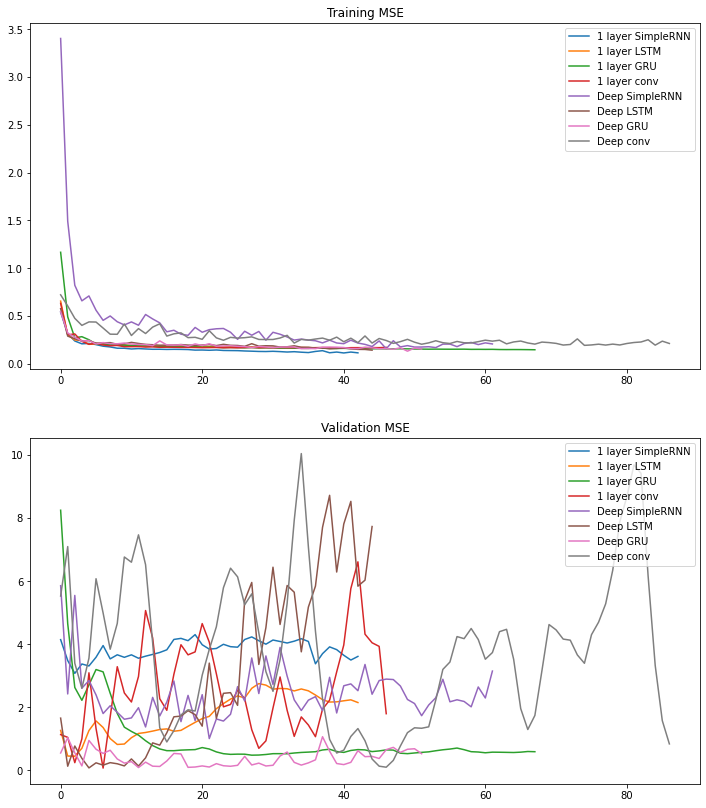

In [28]:
fig, axes = plt.subplots(2, 1, figsize=(12, 14))

for name, his in history.items():
    axes[0].plot(his.history['mse'], label=name)
    axes[0].set_title('Training MSE')
    axes[0].legend()
    axes[1].plot(his.history['val_mse'], label=name)
    axes[1].set_title('Validation MSE')
    axes[1].legend()
plt.show()

In [29]:
training_scaled.shape

(142, 4)

In [30]:
models = [model1, model2, model3, model4, model5, model6, model7, model8]

In [43]:
scores_mse = {"1 layer SimpleRNN": model1.evaluate(x_test, y_test)[1], 
          "1 layer LSTM": model2.evaluate(x_test, y_test)[1], 
          "1 layer GRU": model3.evaluate(x_test, y_test)[1],
          "1 layer conv": model4.evaluate(x_test, y_test)[1],
          "Deep SimpleRNN": model5.evaluate(x_test, y_test)[1],
          "Deep LSTM": model6.evaluate(x_test, y_test)[1],
          "Deep GRU": model7.evaluate(x_test, y_test)[1],
          "Deep conv": model8.evaluate(x_test, y_test)[1]}

1/1 [==============================] - 0s 15ms/step - loss: 1.4344 - mse: 1.4344 - mae: 1.1816 - mape: 39.9302


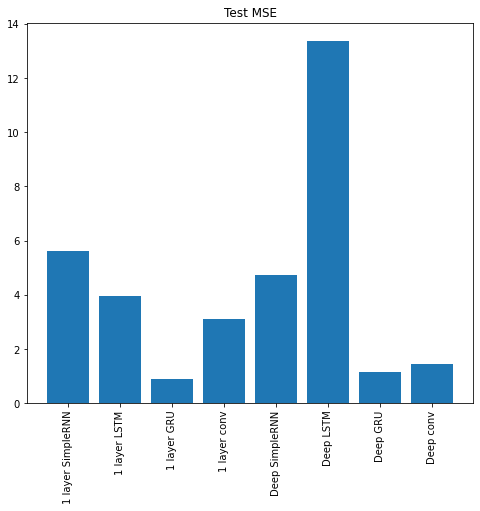

In [42]:
plt.figure(figsize=(8, 7))
plt.bar(range(len(scores_mse)), list(scores_mse.values()), align='center')
plt.xticks(range(len(scores_mse)), list(scores_mse.keys()), rotation='vertical')
plt.title('Test MSE')
plt.show()

In [45]:
scores_mae = {"1 layer SimpleRNN": model1.evaluate(x_test, y_test)[2], 
          "1 layer LSTM": model2.evaluate(x_test, y_test)[2], 
          "1 layer GRU": model3.evaluate(x_test, y_test)[2],
          "1 layer conv": model4.evaluate(x_test, y_test)[2],
          "Deep SimpleRNN": model5.evaluate(x_test, y_test)[2],
          "Deep LSTM": model6.evaluate(x_test, y_test)[2],
          "Deep GRU": model7.evaluate(x_test, y_test)[2],
          "Deep conv": model8.evaluate(x_test, y_test)[2]}

1/1 [==============================] - 0s 13ms/step - loss: 1.4344 - mse: 1.4344 - mae: 1.1816 - mape: 39.9302


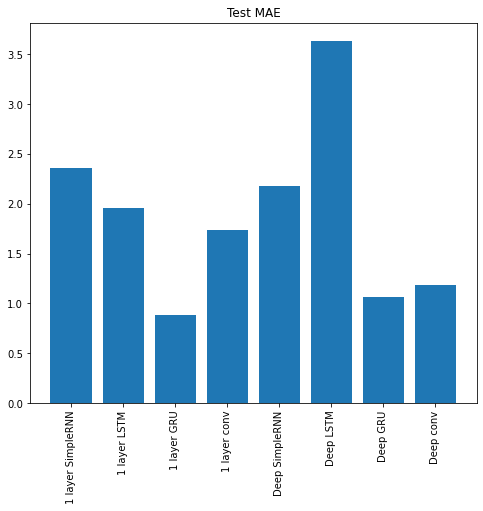

In [46]:
plt.figure(figsize=(8, 7))
plt.bar(range(len(scores_mae)), list(scores_mae.values()), align='center')
plt.xticks(range(len(scores_mae)), list(scores_mae.keys()), rotation='vertical')
plt.title('Test MAE')
plt.show()

In [48]:
scores_loss = {"1 layer SimpleRNN": model1.evaluate(x_test, y_test)[0], 
          "1 layer LSTM": model2.evaluate(x_test, y_test)[0], 
          "1 layer GRU": model3.evaluate(x_test, y_test)[0],
          "1 layer conv": model4.evaluate(x_test, y_test)[0],
          "Deep SimpleRNN": model5.evaluate(x_test, y_test)[0],
          "Deep LSTM": model6.evaluate(x_test, y_test)[0],
          "Deep GRU": model7.evaluate(x_test, y_test)[0],
          "Deep conv": model8.evaluate(x_test, y_test)[0]}

1/1 [==============================] - 0s 17ms/step - loss: 1.4344 - mse: 1.4344 - mae: 1.1816 - mape: 39.9302


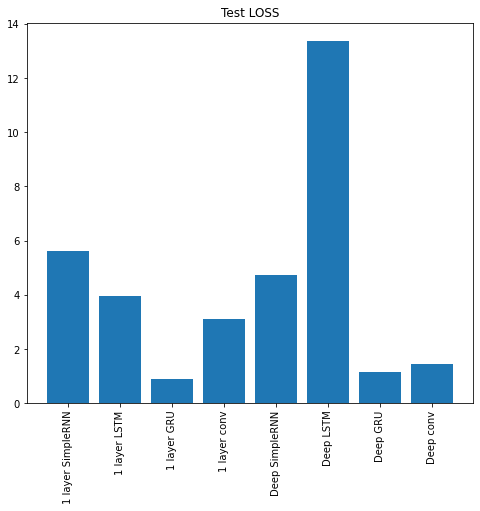

In [49]:
plt.figure(figsize=(8, 7))
plt.bar(range(len(scores_loss)), list(scores_loss.values()), align='center')
plt.xticks(range(len(scores_loss)), list(scores_loss.keys()), rotation='vertical')
plt.title('Test LOSS')
plt.show()

In [50]:
scores_mape = {"1 layer SimpleRNN": model1.evaluate(x_test, y_test)[3], 
          "1 layer LSTM": model2.evaluate(x_test, y_test)[3], 
          "1 layer GRU": model3.evaluate(x_test, y_test)[3],
          "1 layer conv": model4.evaluate(x_test, y_test)[3],
          "Deep SimpleRNN": model5.evaluate(x_test, y_test)[3],
          "Deep LSTM": model6.evaluate(x_test, y_test)[3],
          "Deep GRU": model7.evaluate(x_test, y_test)[3],
          "Deep conv": model8.evaluate(x_test, y_test)[3]}

1/1 [==============================] - 0s 15ms/step - loss: 1.4344 - mse: 1.4344 - mae: 1.1816 - mape: 39.9302


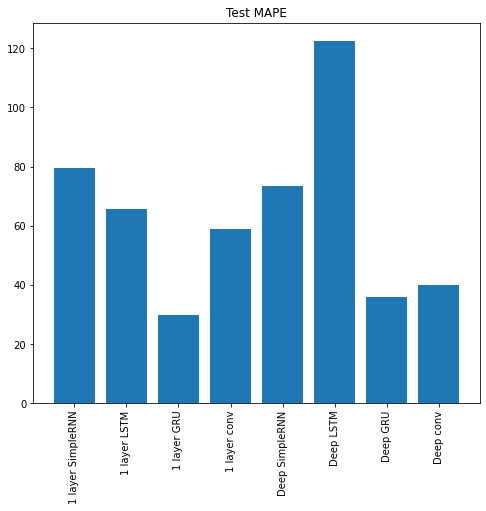

In [51]:
plt.figure(figsize=(8, 7))
plt.bar(range(len(scores_mape)), list(scores_mape.values()), align='center')
plt.xticks(range(len(scores_mape)), list(scores_mape.keys()), rotation='vertical')
plt.title('Test MAPE')
plt.show()